### Relevant Imports

In [3]:
import os
import tensorflow as tf
import warnings
from data_splitter import data_split

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from face_detection import perform_face_detection
from create_custom_model import black_white_model, plot_training_history
from create_custom_model import train_model
from plot_sample_images import plot_images
from evaluate_model import evaluate_classifier

config = tf.compat.v1.ConfigProto()
warnings.filterwarnings("default", category=DeprecationWarning, module=__name__)

In [4]:
PATH = os.getcwd()
input_folder = f'{PATH}/../datasets_directory/dataset'
output_folder = f'{PATH}/../datasets_directory/splitted_dataset'

### Data Cleaning & Preparation
<p>Preprocessing the image dataset before training a black and white face detection model is critical for several technical reasons that enhance model quality and performance:</p>
<ol>
<li>Data Quality Assurance: Removing low-quality or faceless images ensures the training dataset is high-quality, reducing the risk of overfitting to noisy data.
</li><br/>
<li>
Noise Reduction: Eliminating non-face images or low-quality faces reduces dataset noise, improving the model's ability to generalize.
</li><br/>
<li>
Bias Mitigation: Balancing the dataset representation mitigates bias, ensuring a more equitable model.
</li><br/>
<li>
Robust Feature Learning: High-quality data helps the model learn robust and discriminative features for accurate face detection.
</li><br/>
<li>
Alignment and Consistency:
Face detection during preprocessing may involve alignment and normalization, ensuring that all face regions are consistently positioned and scaled.
Consistent alignment helps the model learn invariant features, making it more adaptable to different poses and perspectives of black and white faces.
</li><br/>
<li>
Alignment and Consistency: Consistent alignment aids the model in handling different face poses and perspectives.
</li><br/>
</li>
<li>Training Efficiency: Removing irrelevant images speeds up training, benefiting model development.
</li><br/>
<li>
Enhanced Generalization: A clean dataset fosters better model generalization to real-world scenarios.
</li><br/>
<li>Ethical Compliance: Ensuring the dataset is free from inappropriate content aligns with ethical AI development.
</li>
<br/><br/>
<p>
In summary, the process of exploring, cleaning, and filtering the dataset for black and white face detection using the DeepFace library is essential to enhance data quality, mitigate bias, improve model generalization, and ensure ethical AI development. It aligns with best practices in data preprocessing and contributes to the overall success of the model.</p>

### Process Images:

In [5]:
folder_mapping = {
    'white_faces': 'black_faces',
    'black_faces': 'white_faces'
}

for input_folder, output_folder in folder_mapping.items():
    input_path = f'{PATH}/../datasets_directory/dataset/{input_folder}'
    # output_path = f'{PATH}/../datasets_directory/detected_face_dataset/{output_folder}'
    # perform_face_detection(input_path, output_path)

### Data split:

In [6]:
main_data = f'{PATH}/../datasets_directory/detected_face_dataset'
split_data = f'{PATH}/../datasets_directory/splitted_dataset'
data_split(main_data, split_data, 0.7, 0.15, 0.15)

In [7]:
categories = ['white_faces', 'black_faces']
subsets = ['train', 'val', 'test']
output_folder = f'{PATH}/../datasets_directory/splitted_dataset'
data_location_map = {
    'train_dir': os.path.join(output_folder, "train"),
    'val_dir': os.path.join(output_folder, "val"),
    'test_dir': os.path.join(output_folder, "test")
}

data_counts = {'train': {}, 'val': {}, 'test': {}}

for subset in subsets:
    subset_dir = os.path.join(output_folder, subset)
    for category in categories:
        category_dir = os.path.join(subset_dir, category)
        num_images = len(os.listdir(category_dir))
        data_counts[subset][category] = num_images

print("Data Counts:\n")
for subset, categories_data in data_counts.items():
    print(f"Total {subset.capitalize()} images:")
    for category, count in categories_data.items():
        print(f"\t{category.capitalize()}: {count}")

# Calculate totals
total_train = sum(data_counts['train'].values())
total_val = sum(data_counts['val'].values())
total_test = sum(data_counts['test'].values())

print("----------------------------")
print("Total training images:", total_train)
print("Total validation images:", total_val)
print("Total test images:", total_test)


Data Counts:

Total Train images:
	White_faces: 12250
	Black_faces: 12099
Total Val images:
	White_faces: 3664
	Black_faces: 3580
Total Test images:
	White_faces: 3686
	Black_faces: 3576
----------------------------
Total training images: 24349
Total validation images: 7244
Total test images: 7262


<p> This code is setting up image data generators for training, validation, and test datasets for processing image data. 

The 3 separate instances of the ImageDataGenerator class is often used in with models to preprocess image data.

The line rescale=1./255 means that each pixel's value in the images will be divided by 255,<br>
which effectively scales all pixel values to be in the range between 0 and 1. <br>
This rescaling is a common practice to help the neural network converge faster during training.

These generators are typically used in combination with other functions or methods to load and <br>
 preprocess batches of image data from directories. They can be used with functions like <br>
 flow_from_directory to load images in batches, apply data augmentation techniques, and prepare the data <br>
 for training, validation, or testing of machine learning models. </p>

In [8]:
# Define batch size and number of epochs for training
batch_size = 128
epochs = 10

# Define image dimensions (height and width) for data preprocessing
IMG_HEIGHT = 86
IMG_WIDTH = 86

#### Setting Up Data Generators and Creating Label Mapping

In [9]:
train_image_generator = ImageDataGenerator(rescale=1./255) # Generator for our training data
validation_image_generator = ImageDataGenerator(rescale=1./255) # Generator for our validation data
test_image_generator = ImageDataGenerator(rescale=1./255) # Generator for our validation data

train_data_gen = train_image_generator.flow_from_directory(batch_size=batch_size,
                                                           directory=data_location_map['train_dir'],
                                                           shuffle=True,
                                                           target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                           class_mode='binary')

# Creating Data Generators for Validation and Test Data"
val_data_gen = validation_image_generator.flow_from_directory(batch_size=batch_size,
                                                              directory=data_location_map["val_dir"],
                                                              target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                              class_mode='binary')
test_data_gen = validation_image_generator.flow_from_directory(batch_size=batch_size,
                                                              directory=data_location_map["test_dir"],
                                                              target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                              class_mode='binary')

label_map = (train_data_gen.class_indices)
print(label_map)
label_map = dict((v,k) for k,v in label_map.items())
print(label_map)

Found 24349 images belonging to 2 classes.
Found 7244 images belonging to 2 classes.
Found 7262 images belonging to 2 classes.
{'black_faces': 0, 'white_faces': 1}
{0: 'black_faces', 1: 'white_faces'}


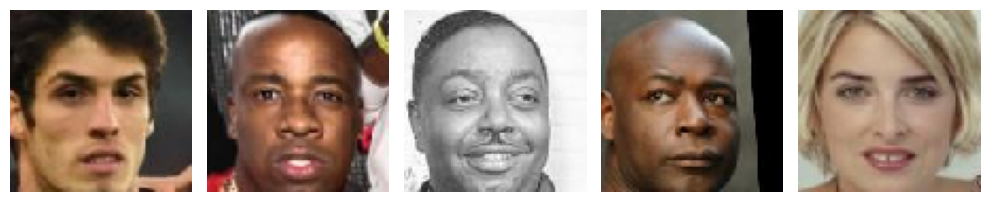

In [10]:
# Assuming you've defined the plot_sample_images function and train_data_gen earlier in your script
sample_training_images, _ = next(train_data_gen)
plot_images(sample_training_images[0:5])

### Create Custom Model(Modeling)

In [11]:
custom_model = black_white_model()
custom_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 86, 86, 16)        448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 43, 43, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 43, 43, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 21, 21, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 21, 21, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 10, 10, 64)        0

In [14]:
model, history = train_model(custom_model, 10, train_data_gen, 128, val_data_gen)

/Users/abigailwoolley/SmileIdentity/Image Classification/BlackVsWhite_Classification/blackwhitefaceDetector/create_custom_model.py:61: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


Epoch 1/10
190/190 [==============================] - ETA: 0s - loss: 0.3114 - accuracy: 0.8493
Epoch 1: saving model to /Users/abigailwoolley/SmileIdentity/Image Classification/BlackVsWhite_Classification/blackwhitefaceDetector/../Epochs_steps/blackWhite-10.h5
190/190 [==============================] - 67s 348ms/step - loss: 0.3114 - accuracy: 0.8493 - val_loss: 0.1863 - val_accuracy: 0.9364
Epoch 2/10


/Users/abigailwoolley/Library/Caches/pypoetry/virtualenvs/blackwhitefacedetector-eFQwdokx-py3.9/lib/python3.9/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


190/190 [==============================] - ETA: 0s - loss: 0.1583 - accuracy: 0.9384
Epoch 2: saving model to /Users/abigailwoolley/SmileIdentity/Image Classification/BlackVsWhite_Classification/blackwhitefaceDetector/../Epochs_steps/blackWhite-10.h5
190/190 [==============================] - 62s 324ms/step - loss: 0.1583 - accuracy: 0.9384 - val_loss: 0.1400 - val_accuracy: 0.9406
Epoch 3/10
190/190 [==============================] - ETA: 0s - loss: 0.1232 - accuracy: 0.9535
Epoch 3: saving model to /Users/abigailwoolley/SmileIdentity/Image Classification/BlackVsWhite_Classification/blackwhitefaceDetector/../Epochs_steps/blackWhite-10.h5
190/190 [==============================] - 62s 324ms/step - loss: 0.1232 - accuracy: 0.9535 - val_loss: 0.1270 - val_accuracy: 0.9450
Epoch 4/10
190/190 [==============================] - ETA: 0s - loss: 0.1005 - accuracy: 0.9616
Epoch 4: saving model to /Users/abigailwoolley/SmileIdentity/Image Classification/BlackVsWhite_Classification/blackwhitefac

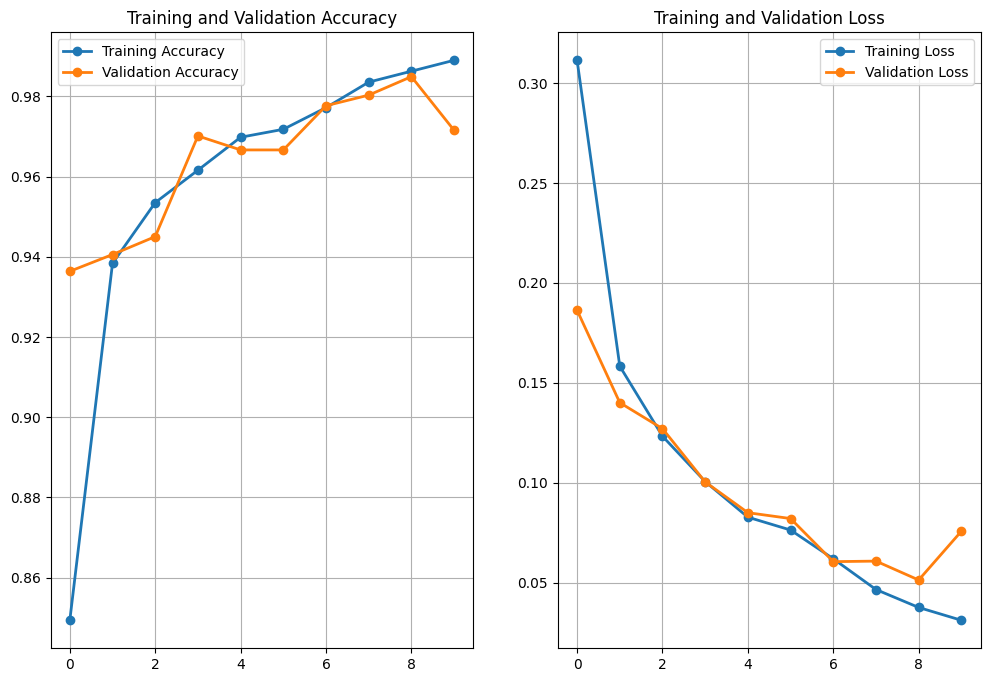

In [15]:
plot_training_history(history)

### Model Evaluation (Inference)

In [13]:
# Load the model and specify the test directory
model = tf.keras.models.load_model(f"{PATH}/Models/blackVswhite_"+str(epochs)+"_"+str(batch_size)+".h5")
results = evaluate_classifier(model, data_location_map["test_dir"])
print("Accuracy:", results['accuracy'])
print("Confusion Matrix:\n", results['confusion_matrix'])
print("Classification Report:\n", results['classification_report'])

Found 7262 images belonging to 2 classes.
227/227 [==============================] - 8s 36ms/step
Accuracy: 0.9819608923161663
Confusion Matrix:
 [[3542   34]
 [  97 3589]]
Classification Report:
               precision    recall  f1-score   support

 white_faces       0.97      0.99      0.98      3576
 black_faces       0.99      0.97      0.98      3686

    accuracy                           0.98      7262
   macro avg       0.98      0.98      0.98      7262
weighted avg       0.98      0.98      0.98      7262



In [ ]:
results = evaluate_classifier(model, data_location_map["test_dir"])
print("Accuracy:", results['accuracy'])
print("Confusion Matrix:\n", results['confusion_matrix'])
print("Classification Report:\n", results['classification_report'])